In [1]:
import numpy as np
import xarray as xr
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature
import pandas as pd

from MapXtremePCIC import MapXtremePCIC

In [2]:
PATH = './data/pr_24hr_50yrs/'

MapXtreme = MapXtremePCIC('110m', 'eof', PATH, 'pr')
data_cube = MapXtreme.load_data

In [3]:
ds, df = MapXtremePCIC.sample(MapXtreme, frac = 0.5)

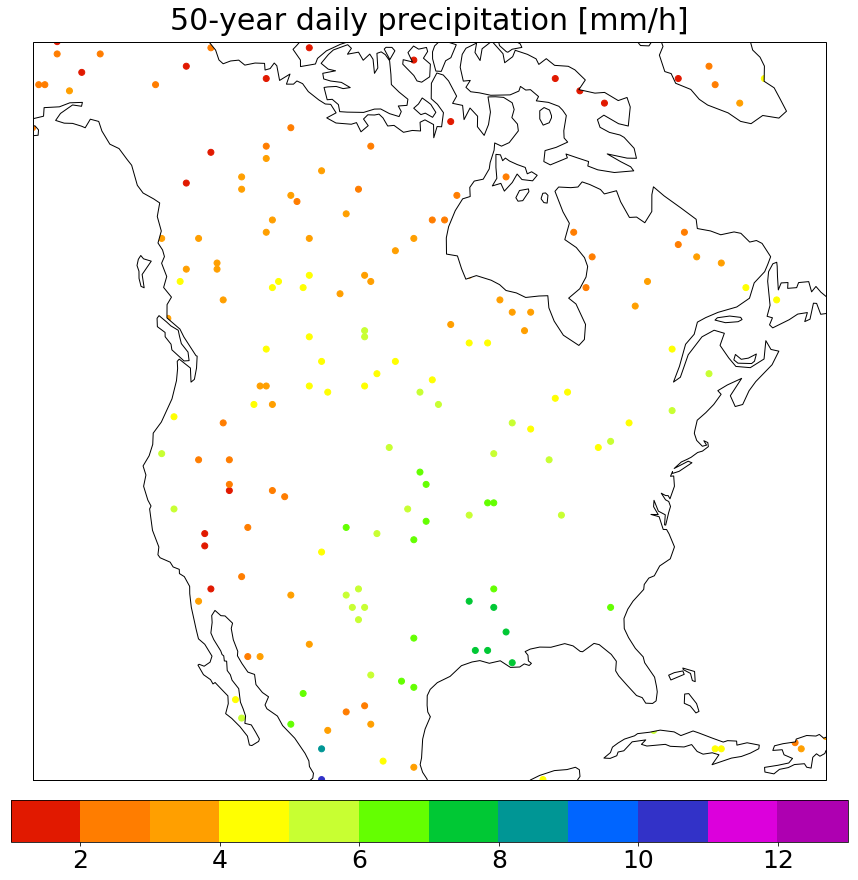

In [12]:
MapXtremePCIC.plot_scatter(MapXtreme, frac = 0.02, run = 2, seed = True)